In [2]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

# prevent BLAS/LAPACK from using multiple threads per process
#os.environ["OMP_NUM_THREADS"] = "1"
#os.environ["OPENBLAS_NUM_THREADS"] = "1"
#os.environ["MKL_NUM_THREADS"] = "1"
#os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from utils import timeit, get_allowed_time_intervals, block_flatten

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [3]:
# possibly extent to more activities

LX = 256
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
d_cluster = dict(path = base_path + '_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = LX, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]


## Choose which dataset to visualize
act = 0.025 #22 
num_exp = 0

folder_path = os.path.join(base_path, f'analysis_zeta_{act}',  f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')

with open(defect_path, 'rb') as f:
    top_defects = pkl.load(f)


#### Coarse-graining of several windows

In [141]:
## we will:
# assume square partion starting from bounds of system


dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 2
coarse_graining_box_length = 8
overlap = 0
nshuffle = 1
nbits = 4

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)
npartitions = compression_factor**2

LX_cg = LX // coarse_graining_box_length
lx_window = LX // compression_factor
lx_window_cg = lx_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = get_allowed_time_intervals(system_size = lx_window_cg, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid = np.zeros((num_frames - first_frame_idx, LX_cg, LX_cg), dtype=dtype)
defect_count_full = []
defect_count = []

print(f'nboxes per frame = {compression_factor**2}')
print(f"Using window size {lx_window}x{lx_window}.")
print(f"nf_cube,lx_cg,ly_cg= {nframes_per_cube}x{lx_window_cg}x{lx_window_cg}")
print(f"Hypercube shape: {1 << nbits}x{1 << nbits}x{1 << nbits}")
print(f"ncubes: {ncubes}")

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    #def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    #def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    #def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (def_arr[:, 0] // coarse_graining_box_length).astype(int)
    coarse_y = (def_arr[:, 1] // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print(defect_count_full)
print(f"Average number of defects in window before/after coarse graining: {np.mean(defect_count_full):.2f}, {np.mean(defect_count):.2f}")
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

nboxes per frame = 4
Using window size 128x128.
nf_cube,lx_cg,ly_cg= 16x16x16
Hypercube shape: 16x16x16
ncubes: 9
[104, 102, 106, 106, 110, 106, 108, 108, 110, 105, 104, 108, 112, 118, 116, 118, 112, 114, 108, 112, 106, 108, 110, 112, 112, 112, 120, 120, 120, 122, 122, 128, 128, 126, 127, 124, 122, 120, 124, 123, 122, 128, 124, 124, 126, 123, 116, 119, 115, 112, 110, 112, 116, 133, 124, 132, 121, 119, 122, 124, 121, 119, 120, 124, 122, 120, 122, 120, 114, 114, 114, 114, 111, 108, 112, 108, 112, 110, 113, 116, 118, 122, 122, 120, 122, 122, 116, 120, 127, 129, 120, 125, 120, 112, 108, 108, 112, 114, 112, 116, 118, 118, 120, 122, 122, 120, 123, 127, 124, 126, 128, 125, 124, 121, 121, 118, 118, 120, 120, 122, 124, 126, 122, 122, 126, 127, 127, 124, 130, 134, 132, 126, 128, 130, 134, 134, 132, 138, 142, 140, 142, 134, 137, 140]
Average number of defects in window before/after coarse graining: 119.88, 114.84


In [ ]:
### 3D CID

t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=False)
cid_arr = np.nan * np.ones((ncubes, npartitions, 2))
cid_shuffle_arr = np.nan * np.ones_like(cid_arr)
cid_frac_arr = np.nan * np.ones_like(cid_arr)

for j in range(ncubes):
    print(f"Calculating CID for cube {j+1}/{ncubes}...", end=' ')
    for i in range(npartitions):
        x_start = (i % compression_factor) * lx_window_cg
        y_start = (i // compression_factor) * lx_window_cg
        data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap, x_start:x_start+lx_window_cg, y_start:y_start+lx_window_cg]
        #print(f"  partition {i+1}/{npartitions}, data sum = {data.sum()}")
        print(f'box bounds: [{x_start},{x_start+lx_window_cg}] x [{y_start},{y_start+lx_window_cg}]')
        cid_av, cid_std, cid_shuff = CID(data)
        cid_arr[j, i, 0] = cid_av
        cid_arr[j, i, 1] = cid_std
        cid_shuffle_arr[j, i, :] = cid_shuff


cid_frac_arr[:, :, 0] = cid_arr[:, :, 0] / cid_shuffle_arr[:, :, 0]
cid_frac_arr[:, :, 1] = cid_frac_arr[:, :, 0] * np.sqrt( (cid_arr[:, :, 1]/cid_arr[:, :, 0])**2 + (cid_shuffle_arr[:, :, 1]/cid_shuffle_arr[:, :, 0])**2 )


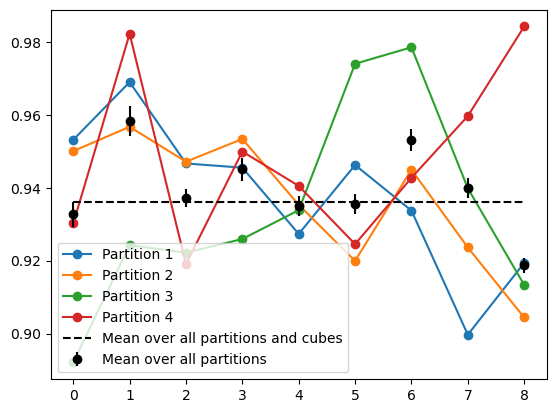

In [148]:
for i in range(npartitions):
    plt.plot(range(ncubes), cid_frac_arr[:, i, 0], marker='o', label=f'Partition {i+1}')

av_w, std_w = calc_weighted_mean(cid_frac_arr[:, :, 0].flatten(), cid_frac_arr[:, :, 1].flatten(), )
av_wt, std_wt = calc_weighted_mean(cid_frac_arr[:, :, 0], cid_frac_arr[:, :, 1],axis=-1 )
plt.hlines(av_w, 0, ncubes-1, colors='k', linestyles='dashed', label='Mean over all partitions and cubes')
plt.errorbar(range(ncubes), av_wt, yerr=std_wt, fmt='o', color='k', label='Mean over all partitions')
#plt.plot(range(ncubes), calc_weighted_mean(cid_frac_arr[:, :, 0], cid_frac_arr[:, :, 1]), marker='o', color='k', label='Mean over partitions')
plt.legend()

#### Coarse-graining of 1 window

In [5]:
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 2
coarse_graining_box_length = 4
overlap = 0
nshuffle = 8
nbits = 5

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)

observation_window_bounds = [(0, int(LX / compression_factor)), (0, int(LX / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]
lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = get_allowed_time_intervals(system_size = lx_window_cg, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid = np.zeros((num_frames - first_frame_idx, lx_window_cg, ly_window_cg), dtype=dtype)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"nf_cube,lx_cg,ly_cg= {nframes_per_cube}x{lx_window_cg}x{ly_window_cg}")
print(f"Hypercube shape: {1 << nbits}x{1 << nbits}x{1 << nbits}")
print(f"ncubes: {ncubes}")

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print(f"Average number of defects in window before/after coarse graining: {np.mean(defect_count_full):.2f}, {np.mean(defect_count):.2f}")
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

Using window size 128x128.
nf_cube,lx_cg,ly_cg= 32x32x32
Hypercube shape: 32x32x32
ncubes: 4
Average number of defects in window before/after coarse graining: 30.22, 29.91


In [54]:
### 2D CID calculation

use_class = True
use_par = True
verbose=False
CID2d = cid2d(nbits=nbits_frame, nshuff=nshuffle,mode=cid_mode, verbose=verbose)
nframes_seq = 10
cid_seq = np.nan*np.ones((nframes_seq, 4))
cid_seq_shuffle = np.nan*np.ones_like(cid_seq)
cid_seq_frac = np.nan*np.ones_like(cid_seq)
cid_uno = []

t0 = time.perf_counter()
for j in range(nframes_seq):
    print(f"Calculating CID for frame {j+1}/{nframes_seq}...", end=' ')
    ff_idx = j
    data = defect_grid[ff_idx,:,:]
    #data = np.ones_like(data)
    #data[:,::2] = 1
    #data[::2,:] = np.random.randint(0,2,size=data[::2,:].shape)
    
    cid_uno.append(cid(data.ravel()))
    if use_class:
        cid_av, cid_std, cid_shuff = CID2d(data)
        cid_seq[j, 0] = cid_av
        cid_seq[j, 1] = cid_std
        cid_seq_shuffle[j, :2] = cid_shuff
    if use_par:
        t1 = time.perf_counter()
        cid_temp = []
        for order in itter_hscan(data, dim=2,nbits=nbits_frame):
            cid_temp.append(cid(order))
        #print(cid_temp)
        if verbose: print(f"CID took {time.perf_counter()-t1:.2f} s")
 
        cid_av = np.mean(cid_temp)
        cid_std = np.std(cid_temp)
        t2= time.perf_counter()
        cid_shuff = cid_shuffle(data.ravel(), nshuff=8, cid_mode=cid_mode)
        if verbose: print(f"CID shuffle took {time.perf_counter()-t2:.2f} s")

        cid_seq[j, 2] = cid_av
        cid_seq[j, 3] = cid_std
        cid_seq_shuffle[j, 2:] = cid_shuff

if use_class:
    print("CID class: ", cid_seq[:,0])
    print("CID class shuffle: ", cid_seq_shuffle[:,0])
    cid_seq_frac[:, 0] = cid_seq[:, 0] / cid_seq_shuffle[:, 0]
    cid_seq_frac[:, 1] = cid_seq_frac[:, 0] * np.sqrt( (cid_seq[:, 1]/cid_seq[:, 0])**2 + (cid_seq_shuffle[:, 1]/cid_seq_shuffle[:, 0])**2 )
if use_par:
    cid_seq_frac[:, 2] = cid_seq[:, 2] / cid_seq_shuffle[:, 2]
    cid_seq_frac[:, 3] = cid_seq_frac[:, 2] * np.sqrt( (cid_seq[:, 3]/cid_seq[:, 2])**2 + (cid_seq_shuffle[:, 3]/cid_seq_shuffle[:, 2])**2 )

    
print(f"cid class mean: {np.nanmean(cid_seq[:,0]):.3f} +/- {np.nanstd(cid_seq[:,0]):.3f}")
print(f"cid class shuffle mean: {np.nanmean(cid_seq_shuffle[:,0]):.3f} +/- {np.nanstd(cid_seq_shuffle[:,0]):.3f}")
print(f"cid par mean: {np.nanmean(cid_seq[:,2]):.3f} +/- {np.nanstd(cid_seq[:,2]):.3f}")
print(f"cid par shuffle mean: {np.nanmean(cid_seq_shuffle[:,2]):.3f} +/- {np.nanstd(cid_seq_shuffle[:,2]):.3f}")
# 
print(f"Done. Total time: {time.perf_counter()-t0:.2f} s")

Calculating CID for frame 1/10... Calculating CID for frame 2/10... Calculating CID for frame 3/10... Calculating CID for frame 4/10... Calculating CID for frame 5/10... Calculating CID for frame 6/10... Calculating CID for frame 7/10... Calculating CID for frame 8/10... Calculating CID for frame 9/10... Calculating CID for frame 10/10... CID class:  [1.25178597 1.25174561 1.23565864 1.21807942 1.24301173 0.30784996
 0.31300893 0.34228581 0.32510003 0.34239395]
CID class shuffle:  [1.40269044 1.41276838 1.41277481 1.39260303 1.41420832 0.31650641
 0.32176324 0.33896763 0.33724264 0.33900669]
cid class mean: 0.783 +/- 0.457
cid class shuffle mean: 0.869 +/- 0.538
cid par mean: 0.783 +/- 0.457
cid par shuffle mean: 0.864 +/- 0.536
Done. Total time: 25.02 s


In [ ]:
### 3D CID

t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=False)
cid_arr = np.nan * np.ones((ncubes, 2))
cid_shuffle_arr = np.nan * np.ones_like(cid_arr)
cid_frac_arr = np.nan * np.ones_like(cid_arr)

for j in range(ncubes):
    print(f"Calculating CID for cube {j+1}/{ncubes}...", end=' ')
    data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap]
    cid_av, cid_std, cid_shuff = CID(data)
    cid_arr[j, 0] = cid_av
    cid_arr[j, 1] = cid_std
    cid_shuffle_arr[j, :] = cid_shuff

cid_frac_arr[:, 0] = cid_arr[:, 0] / cid_shuffle_arr[:, 0]
cid_frac_arr[:, 1] = cid_frac_arr[:, 0] * np.sqrt( (cid_arr[:, 1]/cid_arr[:, 0])**2 + (cid_shuffle_arr[:, 1]/cid_shuffle_arr[:, 0])**2 )

Calculating CID for cube 1/37... Calculating CID for cube 2/37... Calculating CID for cube 3/37... Calculating CID for cube 4/37... Calculating CID for cube 5/37... Calculating CID for cube 6/37... Calculating CID for cube 7/37... Calculating CID for cube 8/37... Calculating CID for cube 9/37... Calculating CID for cube 10/37... Calculating CID for cube 11/37... Calculating CID for cube 12/37... Calculating CID for cube 13/37... Calculating CID for cube 14/37... Calculating CID for cube 15/37... Calculating CID for cube 16/37... Calculating CID for cube 17/37... Calculating CID for cube 18/37... Calculating CID for cube 19/37... Calculating CID for cube 20/37... Calculating CID for cube 21/37... Calculating CID for cube 22/37... Calculating CID for cube 23/37... Calculating CID for cube 24/37... Calculating CID for cube 25/37... Calculating CID for cube 26/37... Calculating CID for cube 27/37... Calculating CID for cube 28/37... Calculating CID for cube 29/37... Calculating CID for cub

Mean CID class: 0.9681 +/- 0.043
Mean CID flattened: 0.9858 +/- 0.036


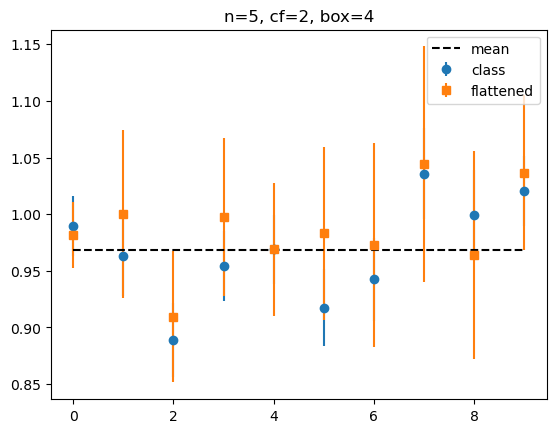

In [14]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,0], yerr=cid_seq_frac[:,1], fmt='o', label=f'class')
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,2], yerr=cid_seq_frac[:,3], fmt='s', label=f'flattened')
ax.hlines(np.nanmean(cid_seq_frac[:,0]), 0, nframes_seq-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID class: {np.nanmean(cid_seq_frac[:,0]):.4f} +/- {np.nanstd(cid_seq_frac[:,0]):.3f}")
print(f"Mean CID flattened: {np.nanmean(cid_seq_frac[:,2]):.4f} +/- {np.nanstd(cid_seq_frac[:,2]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.947 +/- 0.011


Text(0.5, 1.0, 'n=5, cf=2, box=4')

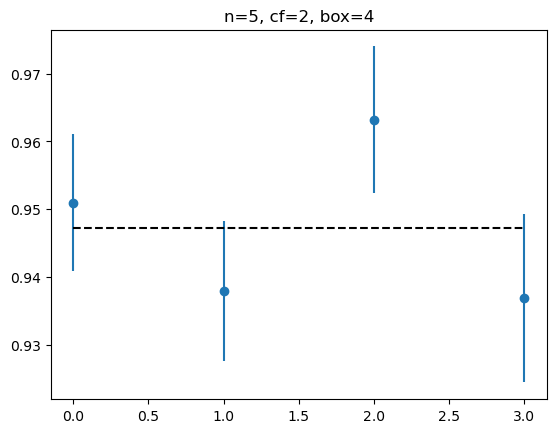

In [242]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

#### Coarse-graining 1 window 1 hypercube

In [ ]:
## thinks:
# dynamic coarse graining box size based on defect density?
# allowing for dynamic nframes to get hypercube slices in time?

compression_factor = 2
coarse_graining_box_length = 4
nframes, nx, ny = 32, d_cluster_l['LX'], d_cluster_l['LX']

observation_window_bounds = [(0, int(nx / compression_factor)), (0, int(ny / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length




defect_grid = np.zeros((nframes, lx_window_cg, ly_window_cg), dtype=int)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"Defect grid shape with coarse graining box length {coarse_graining_box_length}: {defect_grid.shape}")

nbits_frame = int(np.log2(lx_window_cg))

if not lx_window_cg == ly_window_cg:
    raise ValueError("Cg observation windows must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window_cg  , nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

print(f"Using nbits = {nbits} (size {1 << nbits}) for nframes = {nframes} and cg window size {lx_window_cg}x{ly_window_cg}")

for i, defect in enumerate(top_defects[-nframes:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)
   # print(len(def_arr   ))
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print("Average number of defects in window before/after coarse graining: ", np.mean(defect_count_full), np.mean(defect_count))
print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

#### data structure exploration

In [62]:
nbits=4
dim=2
size=1<<nbits
x=np.linspace(1, size**2 , size**2).reshape(-1,size)
x=np.repeat(x[None,:,:,], size, axis=0)
x += np.array([0,100,200,300])[:,None,None]
x=x.astype(np.uint8)
data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
data.squeeze()
x

ValueError: operands could not be broadcast together with shapes (16,16,16) (4,1,1) (16,16,16) 

In [84]:
nbits=3
size=1<<nbits
dim=3
L, Nt = 16,2
L, Nt = 8,8
multiplier = 100 if L==8 else 1000
nbits_frame = int(np.log2(L))

x=np.linspace(1, L**2 , L**2).reshape(-1,L)
x=np.repeat(x[None,:,:,], Nt, axis=0)
x += np.arange(0, multiplier * Nt, multiplier)[:,None,None]
x = x.astype(np.uint16)
x[0]
#data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
#data[:,:,:].squeeze()


array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30, 31, 32],
       [33, 34, 35, 36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45, 46, 47, 48],
       [49, 50, 51, 52, 53, 54, 55, 56],
       [57, 58, 59, 60, 61, 62, 63, 64]], dtype=uint16)

In [88]:
for order in itter_hscan(x, dim=3,nbits=nbits):
    print(order[-10:])

[729 722 707 607 615 715 716 616 608 708]
[737 746 763 663 655 755 756 656 664 764]
[ 37  46  63 163 155  55  56 156 164  64]
[405 506 707 715 615 607 608 616 716 708]
[461 562 763 755 655 663 664 656 756 764]
[361 262  63  55 155 163 164 156  56  64]
[305 206   7  15 115 107 108 116  16   8]
[ 29  22   7 107 115  15  16 116 108   8]


In [ ]:
data = np.transpose(x).reshape((-1, ) + (1<<nbits, ) * dim).T
data[:,:,:].squeeze()

for order in itter_hscan(data, dim=3,nbits=nbits):
    print(order[-1:])

[729 722 707 607 615 715 716 616 608 708]
[737 746 763 663 655 755 756 656 664 764]
[ 37  46  63 163 155  55  56 156 164  64]
[405 506 707 715 615 607 608 616 716 708]
[461 562 763 755 655 663 664 656 756 764]
[361 262  63  55 155 163 164 156  56  64]
[305 206   7  15 115 107 108 116  16   8]
[ 29  22   7 107 115  15  16 116 108   8]


In [91]:
data.shape

(8, 8, 8, 1)

In [90]:

for order in itter_hscan(x[0], dim=2,nbits=nbits_frame):
    print(cid(order))

5.19406587356485
5.269313670049573
5.19406587356485
5.269313670049573
5.19406587356485
5.344143996189747
5.344143996189747
5.19406587356485


In [77]:

for order in itter_hscan(data, dim=2,nbits=nbits_frame):
    print(order)

[57 49 50 58 59 60 52 51 43 44 36 35 34 42 41 33 25 26 18 17  9  1  2 10
 11  3  4 12 20 19 27 28 29 30 22 21 13  5  6 14 15  7  8 16 24 23 31 32
 40 48 47 39 38 37 45 46 54 53 61 62 63 55 56 64]
[64 56 55 63 62 61 53 54 46 45 37 38 39 47 48 40 32 31 23 24 16  8  7 15
 14  6  5 13 21 22 30 29 28 27 19 20 12  4  3 11 10  2  1  9 17 18 26 25
 33 41 42 34 35 36 44 43 51 52 60 59 58 50 49 57]
[ 8 16 15  7  6  5 13 14 22 21 29 30 31 23 24 32 40 39 47 48 56 64 63 55
 54 62 61 53 45 46 38 37 36 35 43 44 52 60 59 51 50 58 57 49 41 42 34 33
 25 17 18 26 27 28 20 19 11 12  4  3  2 10  9  1]
[57 58 50 49 41 33 34 42 43 35 36 44 52 51 59 60 61 53 54 62 63 64 56 55
 47 48 40 39 38 46 45 37 29 21 22 30 31 32 24 23 15 16  8  7  6 14 13  5
  4  3 11 12 20 28 27 19 18 26 25 17  9 10  2  1]
[64 63 55 56 48 40 39 47 46 38 37 45 53 54 62 61 60 52 51 59 58 57 49 50
 42 41 33 34 35 43 44 36 28 20 19 27 26 25 17 18 10  9  1  2  3 11 12  4
  5  6 14 13 21 29 30 22 23 31 32 24 16 15  7  8]
[ 8  7 15 16 24 32 3